Just imports below.

In [1]:
import collections
import gzip
from gensim import models
import numpy as np
import pickle
import tqdm
import util
import gensim.downloader as api
import os

from util import normalize
# We will normalize all vectors because we mostly care about cosines and having all vectors
# normalized reduces cosine to a dot product.

We are using a custom class for embedding models for two reasons:
* to be able to write analogy calculation code from scratch so that we can examine it directly and add variations
* to be able to use the same operations on vectors from gensim and vectors from other sources

Referring to the different items in an analogy can lead to some confusion. In this code, we will refer to the four items in the analogy task as `a`, `a_`, `b`, `b_`. In the canonical example,

`man:woman::king:queen` would be referred to with the names

`a  :a_   ::b   :b_`   


Another slightly inconvenient issue with working with word embeddings is that we deal with tokens, indices, and vectors at different times:
* **tokens** when we collect data, and when we use evaluation sets
* **vectors** when we are calculating cosines, analogies, offsets, etc.
* **indices** when we want to quickly calculate nearest neighbors

To make this easier, I've wrapped up code into the `EmbeddingModel` class, where the instance attributes `self.vectors`, `self.index_to_word`, and `self.word_to_index` help to switch between these ways of referring to the same concept.

I will also refer to the token as `a`, `b`, etc; to indices as `idx_a`, `idx_b`, etc; and vectors as `vec_a`, `vec_b`, etc.


I have implemented the variations of the analogy measurement as methods associated with `EmbeddingModel`, partially to make our code a bit neater.

Note that this code uses `util.Analogy`, which is just a named tuple containing `a`, `a_`, `b`, and `b_s`, defined in `util.py`.



In [2]:
class EmbeddingModel(object):
  def __init__(self, vectors, index_to_word):
    # Since this is only going to be used for analogies, excluding words
    # outside top 300k since that is the norm, and saving normalized vectors
    # so that we can just do dot products to get cosines
    
    self.vectors = np.array([normalize(vec) for vec in vectors[:300000]])
    self.index_to_word = index_to_word[:300000]
    self.word_to_index = {w:i for i, w in enumerate(self.index_to_word)}

  def get_vector_by_word(self, word):
    """Given a token, retrieve its embedding from this model."""
    return self.vectors[self.word_to_index[word]]
  
  def find_nearest_neighbor(self, main_vector, max_neighbors=None):
    """Find a vector's nearest neighbor(s) from this model based on cosine similarity.
    
    Using np.argpartition sometimes saves a little time (50%-ish faster)
    
    Args:
      main_vector: The vector to search from. May be an embedding from this
          model, or a calculated vector.
      max_neighbors: if set, how many nearest neighbors to find. If
          max_neighbors is None, return an ordering over all embeddings in the model.
    
    Returns:
      indices of max_neighbors embeddings (or all embeddings), ordered in decreasing
          order of cosine similarity with main_vector.

    """
    sims = np.dot(self.vectors, -1 * normalize(main_vector))
    if max_neighbors is None:
      return np.argsort(sims).tolist()
    else:
      top_indices = np.argpartition(sims, max_neighbors)[:max_neighbors]
      return sorted(top_indices, key=lambda i:sims[i])
    
  def _vectorise_analogy(self, analogy):
    """Retrieve the relevant embeddings from this model for an analogy question.
    
       Args:
         analogy: a util.Analogy object containing an analogy question

       Returns:
         embeddings for a, a_, and b from the model.
    
    """
    return [self.get_vector_by_word(w) for w in [analogy.a, analogy.a_, analogy.b]]

  def original_analogy(self, analogy):
    """Implements analogy as used in word2vec and GloVe originally.
    
       Calculates a_ + (b-a), finds the nearest neighbor maybe_b_ EXCLUDING {a_, b, a},
       then checks to see if maybe_b_ is in the list of possible b_s.
    """
    vec_a, vec_a_, vec_b = self._vectorise_analogy(analogy)
    approx_vec_b_ = vec_a_ - vec_a + vec_b
    excluded_indices =  [self.word_to_index[w] for w in [analogy.a, analogy.b, analogy.a_]]
    for maybe_b_idx in self.find_nearest_neighbor(approx_vec_b_, max_neighbors=4):
      if maybe_b_idx not in excluded_indices:
        return self.index_to_word[maybe_b_idx] in analogy.b_s
    assert False

  def analogy_no_exclusion(self, analogy):
    """Implements analogy as spoken of colloquially.
    
      Calculates b + (a_ - a), finds the nearest neighbor maybe_b_, which
      may be in the set {a_, b, a}, then checks to see if maybe_b_ is in
      the list of possible b_s.
    """
    vec_a, vec_a_, vec_b = self._vectorise_analogy(analogy)
    approx_vec_b_ = vec_a_ - vec_a + vec_b
    maybe_b_idx, = self.find_nearest_neighbor(approx_vec_b_, max_neighbors=1)
    return self.index_to_word[maybe_b_idx] in analogy.b_s

  def analogy_nearest_b(self, analogy):
    """Implements 'analogy' ignoring a and a_
    
      Returns the nearest neighbor of b. This works well in cases where the a-a_
      and b-b_ distances are very small, e.g. for plurals.
    """
    _, _, vec_b = self._vectorise_analogy(analogy)
    maybe_b_idx = self.find_nearest_neighbor(vec_b, max_neighbors=2)[1]
    return self.index_to_word[maybe_b_idx] in analogy.b_s
  
  def analogy_neighbor_check(self, analogy):
    """Returns the name of the vector b + (a_ - a)'s nearest neighbor (if named)
    
      Args:
        analogy: a util.Analogy
        
      Returns:
        a name from {a, a_, b, b_} if one of these vectors is the nearest neighbor
        of b + (a_ - a). If not, returns 'other'.
    
    """
    vec_a, vec_a_, vec_b = self._vectorise_analogy(analogy)
    approx_vec_b_ = vec_a_ - vec_a + vec_b
    maybe_b_idx, = self.find_nearest_neighbor(approx_vec_b_, max_neighbors=1)
    maybe_b_ = self.index_to_word[maybe_b_idx]
    if maybe_b_ == analogy.a:
      return "a"
    elif maybe_b_ == analogy.a_:
      return "a_"
    elif maybe_b_ == analogy.b:
      return "b"
    elif maybe_b_ in analogy.b_s:
      return "b_"
    else:
      return "other"
    

# This is just to more neatly cycle through the different analogy variations later on
ANALOGY_FN_MAP = {
    "original": lambda x: x.original_analogy,
    "no_exclusion": lambda x: x.analogy_no_exclusion,
    "nearest_b": lambda x: x.analogy_nearest_b,
    #"reversed_original": lambda x: x.reversed_original_analogy
}

Here, we are downloading prepared vectors from gensim, and saving them to disk. We won't run this cell more than once.

Note: this is **a little bit sketchy software engineering-wise**, and it's more just in case the notebook crashes during the tutorial. If you use this code, you will have to ensure that the pickles saved to disk are deleted and re-created whenever you make a change to `EmbeddingModel`.

In [3]:
import gensim.downloader as api
import os

def get_gensim_vectors(vector_name, model_save_name):
  """Retrieve pretrained vectors either from the API or from disk.
  
  Also, write EmbeddingModel object to disk because notebooks keep crashing.
  """
  path = f'data/{model_save_name}.pkl'
  if os.path.exists(path):
    print(f"Loading {model_save_name} from file")
    with open(path, 'rb') as f:
      return pickle.load(f)
  else:
    print(f"Loading {model_save_name} from gensim API")
    gensim_model = api.load(vector_name)
    embedding_model = EmbeddingModel(gensim_model.vectors, gensim_model.index_to_key)
    with open(f'data/{model_save_name}.pkl', 'wb') as f:
      pickle.dump(embedding_model, f)
    return embedding_model

glove = get_gensim_vectors("glove-wiki-gigaword-100", "glove")
w2v =  get_gensim_vectors("word2vec-google-news-300", "w2v")
  

Loading glove from file
Loading w2v from file


Get analogy test sets and embeddings. Test sets are read in using functions in `util.py`.

Notably, rather than having a single `b_`, we have a list of possible `b_`s. This is because in some categories, the BATS dataset has multiple possible b_ values, any of which can be considered correct.

In [4]:
bats_analogy_dataset = util.read_bats_analogy_dataset()
uncased_google_analogy_dataset = util.read_google_analogy_dataset(uncase=True)

Below, we evaluate word2vec embeddings on some variations of the analogy task to shed some light on the analogy results. For brevity, we just run these on the first 200 examples in each category.

The variations we use are:

* "Classic": The classic analogy calculation, matching results in word2vec and GloVe papers, as well as the analogy calculation in the gensim library.
* "No exclusion": If, unlike in the Classic setting, we allow `a`, `a_` and `b` to be possible answers.
  * If the distance between `a` and `a_` is very small, `b` could be the retrieved answer.
  * If `a` and `b` are very close, `a` and `a_` could be the answers.
* "Only b": If we return the nearest neighbor `b` as the answer instead of doing any calculations.
  * If the `a` - `a_` and `b` - `b_` distances tend to be very small, e.g. plurals, this variation could fare well.
  
We also collect results counting how often `a`, `a_` or `b` is the nearest neighbor of `b + (a_ - a)`.

In [20]:
def evaluate_analogy_dataset(dataset, embedding_model, max_per_category=20000):
  """Evaluates an embedding model with an analogy dataset, using different variations.
  
  Args:
  
  Returns:
  
  """
  result_counter = collections.defaultdict(lambda: collections.defaultdict(list))
  neighbor_count = collections.defaultdict(collections.Counter)
  for category, analogies in tqdm.tqdm(list(dataset.items())):
    skipped = 0
    for analogy in analogies[:max_per_category]:
      #print(analogy)
      if not set(list(analogy[:3])+analogy[3]).issubset(embedding_model.index_to_word):
        skipped += 1
        continue
      for eval_type, eval_fn in ANALOGY_FN_MAP.items():
        result_counter[category][eval_type].append(eval_fn(embedding_model)(analogy))
      neighbor_count[category][embedding_model.analogy_neighbor_check(analogy)] += 1
    
  return result_counter, neighbor_count
#%matplotlib notebook

import matplotlib.pyplot as plt
import seaborn as sns


cased_google_analogy_dataset = util.read_google_analogy_dataset(uncase=False)
for dataset in [cased_google_analogy_dataset, 
                #bats_analogy_dataset
               ]:
    results = evaluate_analogy_dataset(dataset, w2v)

100%|██████████████████████████████████████████████| 14/14 [32:29<00:00, 139.23s/it]


[[0.00000000e+00 3.95256917e-03 5.35573123e-01 4.44664032e-01
  1.58102767e-02]
 [0.00000000e+00 1.44230769e-02 7.14743590e-01 2.67399267e-01
  3.43406593e-03]
 [0.00000000e+00 1.98621808e-02 8.73125253e-01 1.02148358e-01
  4.86420754e-03]
 [0.00000000e+00 3.37765957e-01 2.95212766e-01 2.39361702e-01
  1.27659574e-01]
 [0.00000000e+00 2.76679842e-02 6.44268775e-01 3.26086957e-01
  1.97628458e-03]
 [0.00000000e+00 1.51209677e-02 9.67741935e-01 1.51209677e-02
  2.01612903e-03]
 [0.00000000e+00 4.92610837e-02 9.33497537e-01 1.72413793e-02
  0.00000000e+00]
 [0.00000000e+00 9.75975976e-03 7.43243243e-01 2.46996997e-01
  0.00000000e+00]
 [0.00000000e+00 1.33689840e-02 8.75222816e-01 1.10516934e-01
  8.91265597e-04]
 [0.00000000e+00 9.46969697e-04 9.29924242e-01 6.91287879e-02
  0.00000000e+00]
 [0.00000000e+00 1.18824265e-02 1.91369606e-01 7.37961226e-01
  5.87867417e-02]
 [0.00000000e+00 1.92307692e-03 9.08333333e-01 8.58974359e-02
  3.84615385e-03]
 [0.00000000e+00 0.00000000e+00 9.527027

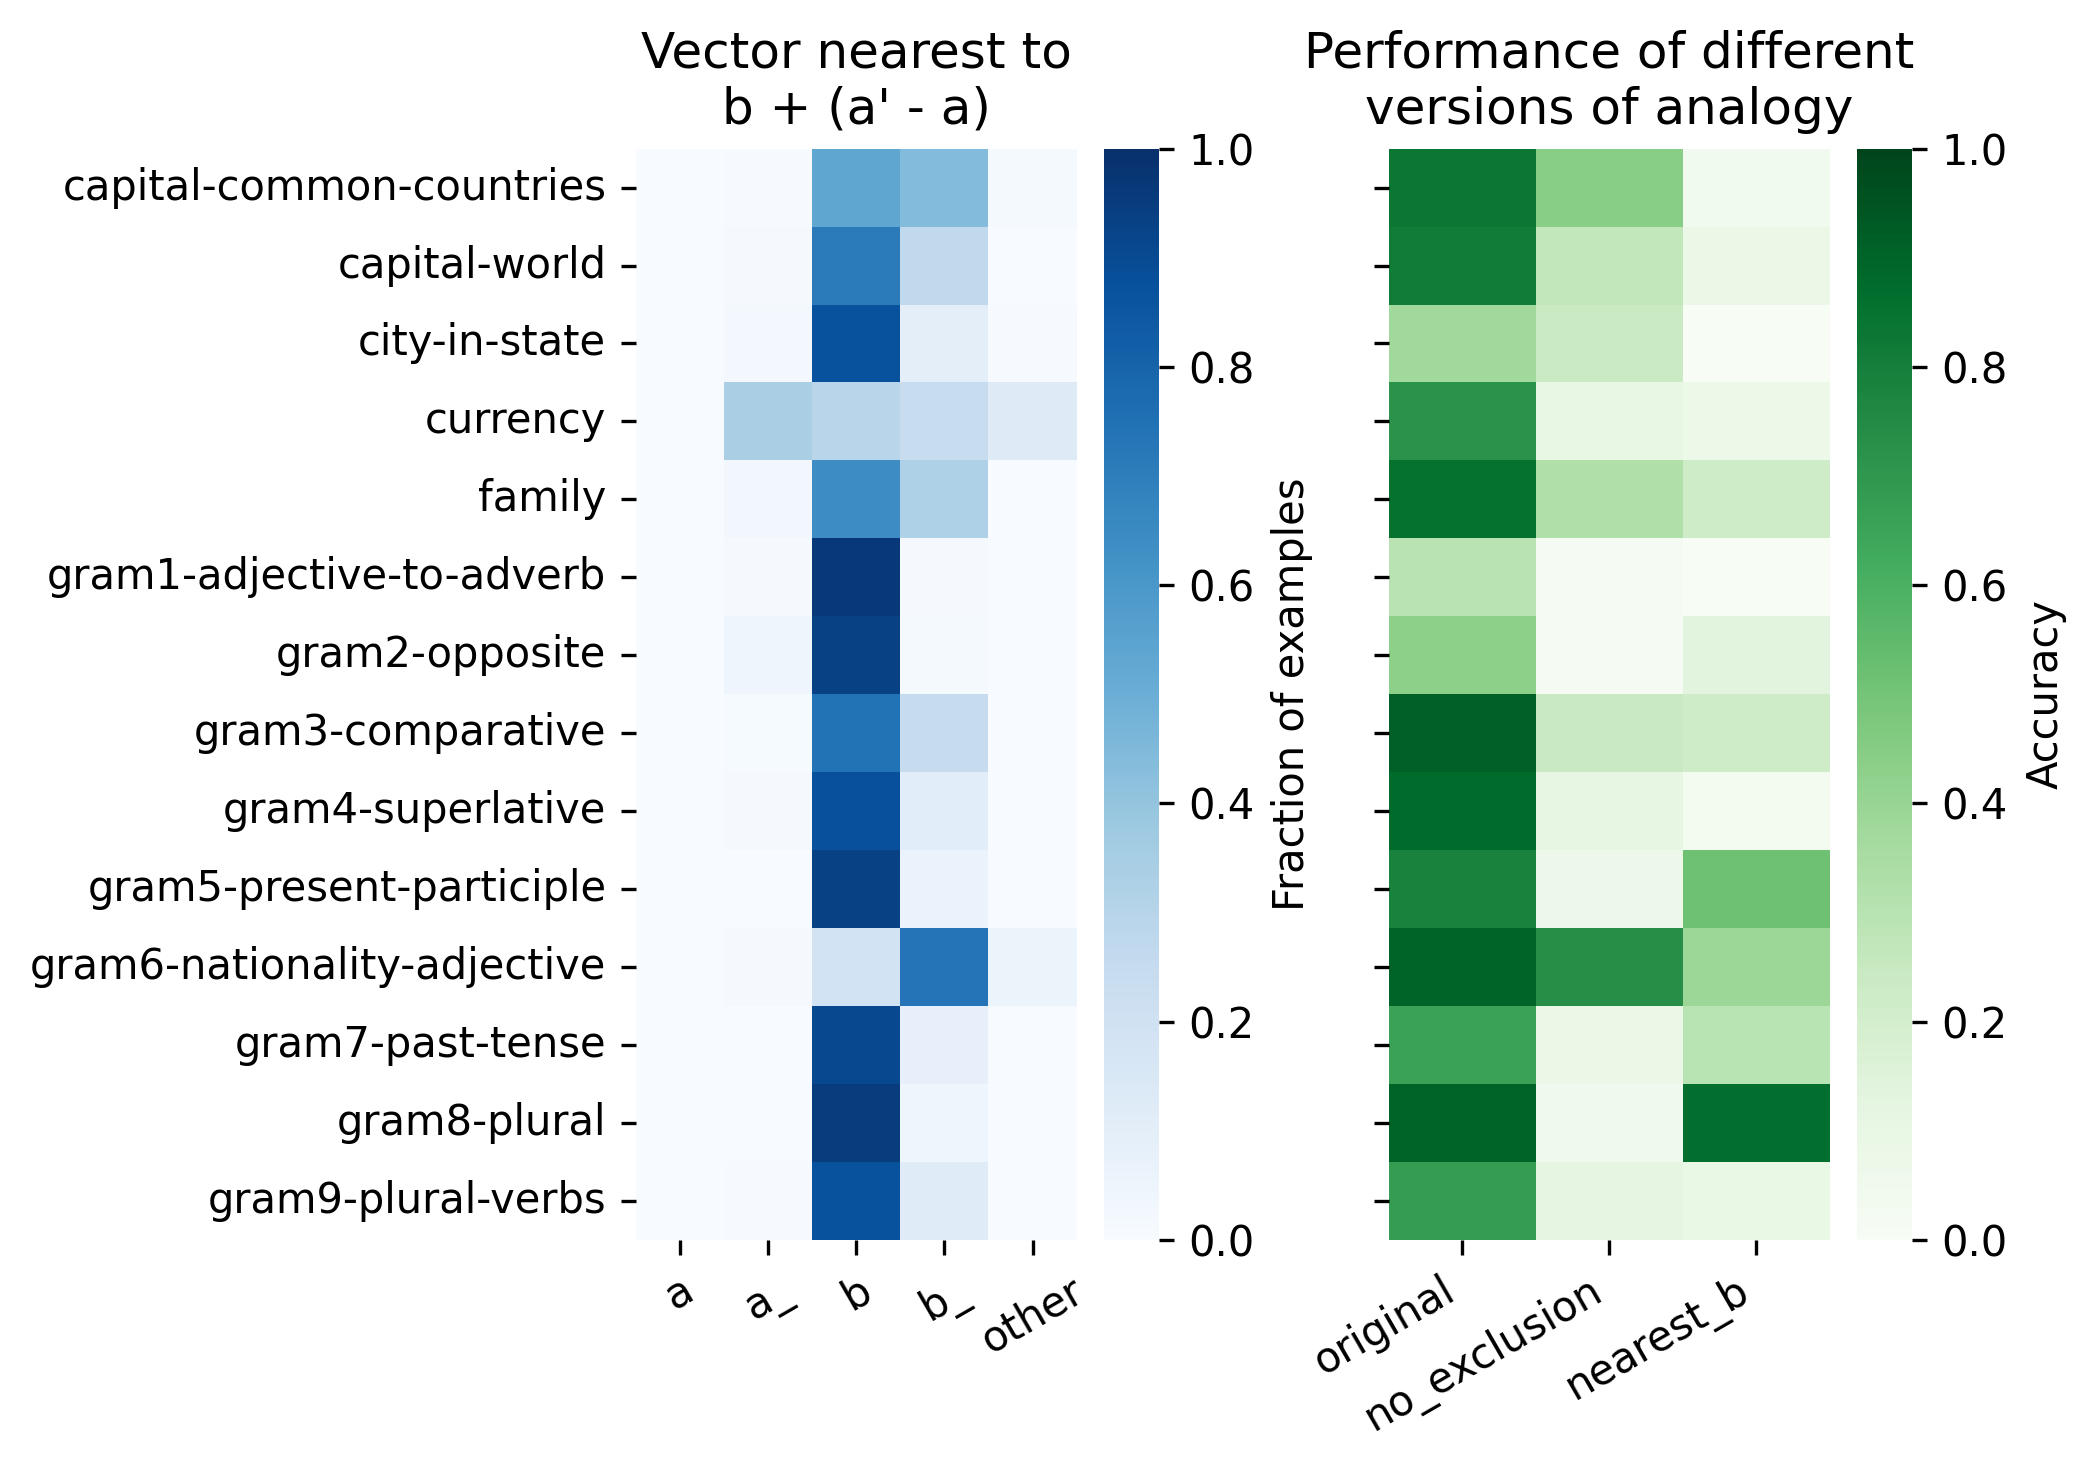

In [26]:

def plot_analogy_results(analogy_results):
  result_counter, neighbor_counter = analogy_results
  
  sorted_categories = sorted(neighbor_counter.keys())
  
  neighbor_array = np.zeros([len(neighbor_counter), 5])
  for i, key in enumerate(sorted_categories):
    denom = 0
    for j, possible_answer in enumerate("a a_ b b_ other".split()):
      neighbor_array[i][j] =  neighbor_counter[key][possible_answer]
      denom +=  neighbor_counter[key][possible_answer]
    for j in range(5):
      neighbor_array[i][j] /= denom
      
  analogy_style_array = np.zeros([len(result_counter), 3])
  for i, key in enumerate(result_counter.keys()):
    results = result_counter[key]
    for j, style in enumerate("original no_exclusion nearest_b".split()):
      analogy_style_array[i][j] =  sum(results[style])/len(results[style])
      
  print(neighbor_array)

      
  fig, ax = plt.subplots(1,2, figsize=(7,5), dpi=300, sharey=True)
  sns.heatmap(neighbor_array, ax=ax[0], cmap="Blues", vmin=0, vmax=1,
                             cbar_kws={'label': 'Fraction of examples'})
  ax[0].set_title("Vector nearest to\nb + (a' - a)")
  ax[0].set_xticklabels("a a_ b b_ other".split(), rotation=30, ha='center')
  ax[0].set_yticklabels(sorted_categories, rotation=0)
  
  
  sns.heatmap(analogy_style_array, ax=ax[1], vmin=0, vmax=1, cmap="Greens", 
                             cbar_kws={'label': 'Accuracy'})
  ax[1].set_title("Performance of different\nversions of analogy")
  ax[1].set_xticklabels("original no_exclusion nearest_b".split(), rotation=30, ha='right')
  ax[1].set_yticklabels(sorted_categories, rotation=0)
  
  
  plt.tight_layout()

plot_analogy_results(results)    
plt.savefig('embeddings.png')
    

In this section, we present a quick litmus test for semantic projection research.

If we define a semantic dimension based on n pairs of antonyms, one way to check the robustness of this dimension is to hold out one pair of antonyms, and ensure that the 'positive' held-out antonym is closer to the positive end of the semantic dimension than the 'negative' held-out antonym. We plot these two cosines on the x and y axis below.

We use word lists and vectors from [Geometry of Culture](??) in this section.

In [6]:
employment_pairs = [('employer', 'employee'), ('employers', 'employees'), ('owner', 'worker'), 
                    ('proprietor', 'employee'), ('proprietors', 'employees'),
                    ('capitalist', 'proletarian'), ('capitalists', 'proletariat'),
                    ('manager', 'staff'), ('managers', 'staff'), ('director', 'employee'),
                    ('directors', 'employees'), ('boss', 'worker'), ('bosses', 'workers'),
                    ('foreman', 'laborer'), ('foremen', 'laborers'), ('supervisor', 'staff'),
                    ('superintendent', 'staff')]

employer_words, employee_words = zip(*employment_pairs)

def get_coha_embeddings(year):
    with open(f"sgns/{year}-vocab.pkl", 'rb') as f:
        vocab = pickle.load(f)
    vectors = np.load(f"sgns/{year}-w.npy")
    return EmbeddingModel(vectors, vocab)
  
coha = get_coha_embeddings(1960)



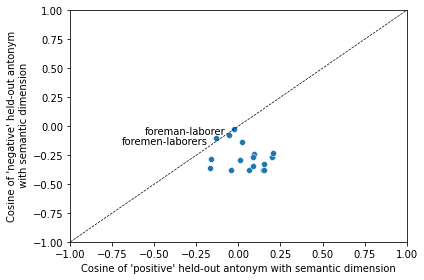

In [7]:
def cosine(a, b):
  return np.dot(normalize(a), normalize(b))


def semantic_dimension_litmus_test(antonym_pairs, embeddings):
  cosine_list = []
  for held_out_pair in antonym_pairs:
    # Get the rest of the pairs
    retained_pairs = [pair for pair in antonym_pairs if not pair == held_out_pair]

    # Separate the 'positive' and 'negative' antonyms, and sum each set into a positive and negative vector
    retained_pos, retained_neg = zip(*retained_pairs)
    pos_vector = sum([embeddings.get_vector_by_word(word) for word in retained_pos])
    neg_vector = sum([embeddings.get_vector_by_word(word) for word in retained_neg])

    # Build the semantic dimension vector by taking the difference of the positive and negative vectors
    diff_vector = pos_vector - neg_vector


    cosine_list.append((held_out_pair, 
                        cosine(diff_vector, embeddings.get_vector_by_word(held_out_pair[0])),
                        cosine(diff_vector, embeddings.get_vector_by_word(held_out_pair[1])),
                       ))

  names, x, y = zip(*cosine_list)
  fig, ax = plt.subplots()
  sns.scatterplot(x=x, y=y, ax=ax)
  ax.set_ylim(-1,1)
  ax.set_xlim(-1,1)
  ax.set_xlabel("Cosine of 'positive' held-out antonym with semantic dimension")
  ax.set_ylabel("Cosine of 'negative' held-out antonym\n with semantic dimension")
  
  for name, x, y in cosine_list:
    if x < y:
        ax.text(x=x-.05, y=y-.05, s="-".join(name),ha='right')

  plt.plot([-1,1], [-1, 1], linestyle="dashed", lw=0.7, color="k")
  plt.tight_layout()
    
semantic_dimension_litmus_test(employment_pairs, coha)
print()


